Import des librairies

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pythermalcomfort import two_nodes
from SALib.analyze import rbd_fast
from SALib.sample import latin
from SALib.plotting.bar import plot as barplot


In [2]:

current_directory = os.getcwd()

# List all files in the current directory
files = os.listdir(current_directory)

# Iterate through all files
for file in files:
    if file.endswith('.py'):
        # Skip Python files
        continue
    else:
        # Delete non-Python files
        os.remove(os.path.join(current_directory, file))

In [3]:
model = "Gagge's Two-Nodes" # Name of model for plot titles
filename='GAGGE_2NODES' # Eventual filename for exporting all csv outputs
doyouwanttoploteverything = True  # Flag if will to export all data in csv and all plot for each degree step (True if will to plot)

In [4]:
def model4sa(tdb,
                tr,
                v,
                rh,
                met,
                clo,
                standard="ASHRAE", limit_inputs=False, round=False):
    
    pythermal=two_nodes(tdb=tdb,
                        tr=tr,
                        v=v,
                        rh=rh,
                        met=met,
                        clo=clo,
                        standard="ASHRAE", limit_inputs=False, round=False)
    
    pts = 0.25 * pythermal['_set'] - 6.03
    es=1.33
    l=0.195
    tsv_se = es * pts
    tsv_sa = pts/(1+l*pts)
    
    return {"_set": pythermal['_set'],
                    "et":pythermal['et'],
                    "t_core" : pythermal['t_core'],
                    "t_skin" : pythermal['t_skin'],
                    "pmv_gagge" : pythermal['pmv_gagge'],
                    "pmv_set" : pythermal['pmv_set'],
                    'w' : pythermal['w'],
                    'w_max' : pythermal['w_max'],
                    "disc" : pythermal['disc'],
                    "t_sens" : pythermal['t_sens'],
                    'pts' : pts,
                    'tsv_se':tsv_se,
                    'tsv_sa':tsv_sa}

In [5]:
model_output_names="_set"
                    # "et",
                    # "t_core",
                    # "t_skin",
                    # "pmv_gagge",
                    # "pmv_set",
                    # 'w',
                    # 'w_max',
                    # "disc",
                    # "t_sens",
                    # 'pts',
                    # 'tsv_se',
                    # 'tsv_sa'
                    
                    

In [6]:
# Define number of sample for SA, need to be determined after a Si (S1) convergence study
samples=10000
# Define input variable ranges based on possible model inputs
lower_v = 0.01 
upper_v = 2.2
# lower_met = 0.65
# upper_met = 1.26
lower_clo = 0.29
upper_clo = 0.79
lower_tdb = 25.4
upper_tdb = 32.1
lower_tr = 23.1
upper_tr = 31.2
lower_rh = 60
upper_rh = 90

In [7]:
# Define SA problem (SALIB package)
problem = {
    'num_vars': 5, # number of variable inputs
    'names': [ 'tdb','tr','rh','v','clo'], # input names in correct order
    'bounds': [
        [lower_tdb, upper_tdb],
        [lower_tr, upper_tr],
        [lower_rh, upper_rh],
        [lower_v, upper_v],
        [lower_clo, upper_clo]
            ],
    'dist' : ['unif',
              'unif',
              'unif',
              'unif',
              'unif']    
            
        }

In [22]:
# Generate the parameter samples using SALIB RBDfast recommanded method (Latin Hypercube sampling)
sampling = latin.sample(problem, samples)
# Evaluate model
Y = [model4sa(tdb=params[0],
                    tr=params[1],
                    rh=params[2],
                    v=params[3],
                    met=1.1,
                    clo=params[4],
                    standard="ASHRAE", limit_inputs=False, round=False)[model_output_names] for params in sampling
                    ]

In [23]:
print(Y)
Y_df=pd.DataFrame(Y, columns=['Y'])

[array(29.53599192), array(27.83626877), array(26.22971079), array(27.94487937), array(24.13992805), array(27.10506705), array(24.39041098), array(21.77677158), array(23.43388551), array(25.70076675), array(29.4367636), array(21.28388729), array(22.69119602), array(25.52423612), array(24.30107846), array(24.01721295), array(26.05860521), array(29.71761393), array(27.08390652), array(29.6851887), array(26.52546769), array(30.04713886), array(29.94510059), array(27.19256397), array(25.91345104), array(28.31991832), array(26.55004989), array(24.11556994), array(22.65247888), array(24.14479519), array(23.36318946), array(25.51681931), array(27.72944775), array(21.08074103), array(28.75459252), array(26.60608656), array(30.85656032), array(28.96052395), array(28.47111187), array(23.90994511), array(25.17019692), array(20.79561597), array(24.90806359), array(24.64341735), array(29.681264), array(22.18623315), array(29.60184588), array(28.11219333), array(29.48770328), array(27.64644163), arr

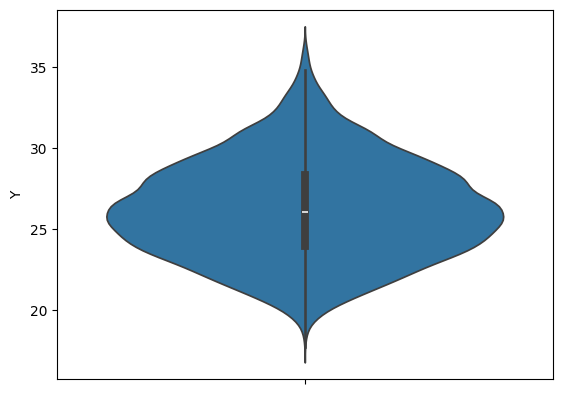

In [10]:
violin=sns.violinplot(data=Y_df, y=Y['Y'])

In [24]:
Si = rbd_fast.analyze(problem, sampling, np.asarray(Y), print_to_console=False)
print(Si)

{'S1': [0.40948463902152193, 0.08044360192523978, 0.04119628017955516, 0.20771924153372887, 0.2350601216835171], 'S1_conf': [0.022741523629022462, 0.015167303253804188, 0.011038783663679077, 0.018012382259150764, 0.018880513400907198], 'names': ['tdb', 'tr', 'rh', 'v', 'clo']}


         S1   S1_conf names
0  0.409485  0.022742   tdb
1  0.080444  0.015167    tr
2  0.041196  0.011039    rh
3  0.207719  0.018012     v
4  0.235060  0.018881   clo


[Text(0, 0, 'tdb'),
 Text(1, 0, 'tr'),
 Text(2, 0, 'rh'),
 Text(3, 0, 'v'),
 Text(4, 0, 'clo')]

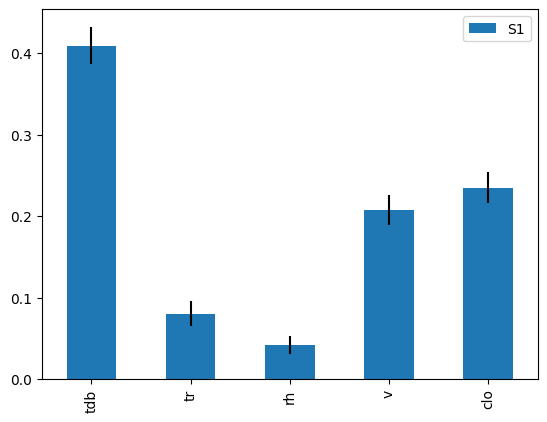

In [25]:
# plt.title='Indice de Sobol du premier ordre'
Si_df=pd.DataFrame(Si)
print(Si_df)
names=Si['names']
ax=barplot(Si_df)
ax.set_xticks(range(len(names)))
ax.set_xticklabels(names)

In [13]:
plot(problem, Si, threshold=0.05, names_latex=None)

NameError: name 'plot' is not defined